In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%cd /content/drive/My\ Drive/Colab\ Notebooks/Project/
!ls -la

/content/drive/My Drive/Colab Notebooks/Project
total 1310220
-rw------- 1 root root 152979584 Apr 27 16:50 decoder_nmt_lstmbidim_gnhind2.pkl
-rw------- 1 root root 152979586 Apr 27 20:37 decoder_nmt_lstmbidim_gnhind3.pkl
-rw------- 1 root root 152979594 Apr 25 06:25 decoder_nmt_lstmbidim_gnhind.pkl
-rw------- 1 root root 457787501 Apr 20 09:49 decoder_nmt.pkl
-rw------- 1 root root  66344095 Apr 27 16:52 encoder_nmt_lstmbidim_gnhind2.pkl
-rw------- 1 root root  66344095 Apr 27 20:37 encoder_nmt_lstmbidim_gnhind3.pkl
-rw------- 1 root root  66344095 Apr 25 06:25 encoder_nmt_lstmbidim_gnhind.pkl
-rw------- 1 root root 129761160 Apr 20 09:49 encoder_nmt.pkl
-rw------- 1 root root     40280 Apr 23 07:59 NMT_Eng2Hin_Shreiya.ipynb
drwx------ 2 root root      4096 Apr 20 03:24 parallel
-rw------- 1 root root  96098008 Apr 19 17:14 parallel.tgz


In [0]:
# Download parallel.tgz from IIT Bombay English Hindi parallel corpus (http://www.cfilt.iitb.ac.in/iitb_parallel/) and Extract it
!tar zxvf parallel.tgz

parallel/
parallel/IITB.en-hi.hi
parallel/IITB.en-hi.en


In [0]:
# Combining English and Hindi file with tab separation
!paste -d "\t" parallel/IITB.en-hi.en parallel/IITB.en-hi.hi > parallel/eng-hin.txt

In [0]:
# Use below commands to extract sentences corresponding to the source we are interested in

!sed -n 1,145706p parallel/eng-hin.txt > parallel/gnome.txt
!sed -n 145707,242933p parallel/IITB.en-hi.en > parallel/kde4.txt
# !sed -n 430014,434711p parallel/eng-hin.txt > parallel/tatoeba.txt
# !sed -n 434712,438933p par  allel/eng-hin.txt > parallel/opensubs.txt
!sed -n 438934,712818p parallel/eng-hin.txt > parallel/hindencorp.txt
# !sed -n 712819,887993p parallel/eng-hin.txt > parallel/wordnet.txt
# !sed -n 887994,954467p parallel/eng-hin.txt > parallel/mahaadd.txt
# !sed -n 954468,1001292p parallel/eng-hin.txt > parallel/mahaade.txt
# !sed -n 1001293,1047815p parallel/eng-hin.txt > parallel/mahaadde.txt
# !sed -n 1047815,1090398p parallel/eng-hin.txt > parallel/ted.txt

In [0]:
# Combining Gnome and HindEnCorp sentences
!cat parallel/gnome.txt parallel/hindencorp.txt > parallel/eng-hin_gnhind.txt

In [0]:
# Length of dataset
!wc -l parallel/eng-hin_gnhind.txt

419591 parallel/eng-hin_gnhind.txt


In [0]:
# Some examples
!tail -20 parallel/eng-hin_gnkdhind.txt

Certain other tests may be necessary for special cases.	विशेष स्थितियों में कुछ अन्य परीक्षणों की भी जरूरत होती है. 
Encrypt all my data	मेरा सभी डेटा एन्क्रिप्ट करें
Group By...	इस आधार पर समूहीकृत
It is now widening its boundaries and it may invade the so - called invisible world before long and help us to understand this purpose of life in its widest sense, or at least give us some glimpses which illumine the problem of human existence.	अब यह अपनी सीमाओं को फैला रहा है और हो सकता है कि इसका हमला हमारी उस दुनिया पर हो, जिसे अदृश्य कहा जाता है और जिंदगी के मकसद को इसके बड़े बड़े अर्थ में समझने में हमारी मदद करे या कम से कम कुछ ऐसी रोशनी दे, जिससे मनुष्य के अस्तित्व की समस्याएं हल हो सकें. 
Israelis are beginning to note the change on the Palestinian side. Former Mossad head Ephraim Halevy has commented on “the buds of Palestinian recognition” of the mistake in turning to violence. The chief of Israel 's Ground Forces Command, Yiftah Ron - Tal, went further and in November predicted wi

In [0]:
# Import required packages
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
# Defining language class

SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1


In [0]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


# Normalizing sentences of both English and Hindi 
def normalizeString(s):
    s = s.lower().strip()
    s = re.sub('\s*_\s*', '', s)
    s = re.sub(r'\([^)]*\)', '', s)
    s = re.sub(r"([.!?])", r" \1", s)
    table = str.maketrans('', '', string.punctuation)
    s = s.translate(table)
    s = re.sub(r"[….!?]+", r" ", s).strip()
    return s

In [0]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('parallel/eng-hin_gnhind.txt',encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [0]:
MAX_LENGTH = 15


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [0]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'hin', False)
print(random.choice(pairs))

Reading lines...
Read 419591 sentence pairs
Trimmed to 324580 sentence pairs
Counting words...
Counted words:
eng 54515
hin 69153
['custom binary', 'मनपसंद एलार्मः']


In [0]:
random.choice(pairs)

['because open market purchase would have made the acquisition costlier',
 'क्योंकि सीधे बाजार से खरीदना मंहगा पड़']

In [0]:
%matplotlib inline
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers = 2, bidirectional = True)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.lstm(output, hidden)
        forward_output, backward_output = output[:, :, :self.hidden_size], output[:, :, self.hidden_size:]
        output = torch.cat((forward_output, backward_output))
        return output, hidden

    def initHidden(self):
        return (torch.zeros(4, 1, self.hidden_size, device=device), torch.zeros(4, 1, self.hidden_size, device=device))

In [0]:
%matplotlib inline
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [0]:
%matplotlib inline
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.lstm = nn.LSTM(self.hidden_size, self.hidden_size, num_layers = 2, bidirectional = True)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0][0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.lstm(output, hidden)
        
        forward_output, backward_output = \
            output[:, :, :self.hidden_size], output[:, :, self.hidden_size:]
        
        output = torch.cat((forward_output, backward_output))
        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return (torch.zeros(4, 1, self.hidden_size, device=device), torch.zeros(4, 1, self.hidden_size, device=device))

In [0]:
def indexesFromSentence(lang, sentence):
    %matplotlib inline
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [0]:
%matplotlib inline
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()
    %matplotlib inline

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        
        encoder_outputs[ei] = encoder_output[0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [0]:
%matplotlib inline
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [0]:
random.choice(pairs)

['distance measures', 'खगोलीय दूरियों']

In [0]:
len(pairs)

324580

In [0]:
%matplotlib inline
def trainIters(encoder, decoder, n_epochs, learning_rate, print_every=50000, plot_every=50000):
    %matplotlib inline
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(pairs[i]) for i in range(len(pairs))]
    criterion = nn.NLLLoss()
    
    n_iters = len(pairs)
    for e in range(1, n_epochs + 1):
        for iter in range(1, len(pairs) + 1):
            training_pair = training_pairs[iter - 1]
            input_tensor = training_pair[0]
            target_tensor = training_pair[1]

            loss = train(input_tensor, target_tensor, encoder,
                        decoder, encoder_optimizer, decoder_optimizer, criterion)
            print_loss_total += loss
            plot_loss_total += loss

            if iter % print_every == 0:
                print_loss_avg = print_loss_total / print_every
                print_loss_total = 0
                print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                            iter, iter / n_iters * 100, print_loss_avg))

            if iter % plot_every == 0:
                plot_loss_avg = plot_loss_total / plot_every
                plot_losses.append(plot_loss_avg)
                plot_loss_total = 0

    showPlot(plot_losses)


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    %matplotlib inline
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [0]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    %matplotlib inline
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [0]:
def evaluateRandomly(encoder, decoder, n=5):
    from nltk.translate.bleu_score import sentence_bleu
    %matplotlib inline
    for i in range(n):
        pair = random.choice(pairs)
        print('English: ', pair[0])
        print('Actual: ', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('Predicted: ', output_sentence)
        act = pair[1].split()
        pred = output_sentence.split()
        print('Cumulative 1-gram: %f' % sentence_bleu([act], pred, weights=(1, 0, 0, 0)))
        print('Cumulative 2-gram: %f' % sentence_bleu([act], pred, weights=(0.5, 0.5, 0, 0)))
        print('Cumulative 3-gram: %f' % sentence_bleu([act], pred, weights=(0.33, 0.33, 0.33, 0)))
        print('Cumulative 4-gram: %f' % sentence_bleu([act], pred, weights=(0.25, 0.25, 0.25, 0.25)))
        score = sentence_bleu([act], pred)
        print(score)
        print('')

23m 0s (- 126m 19s) (50000 15%) 3.2120
44m 39s (- 100m 18s) (100000 30%) 2.1519
67m 9s (- 78m 10s) (150000 46%) 2.7204
91m 29s (- 56m 59s) (200000 61%) 5.2511
115m 30s (- 34m 27s) (250000 77%) 4.9018
139m 33s (- 11m 26s) (300000 92%) 4.6720


<Figure size 432x288 with 0 Axes>

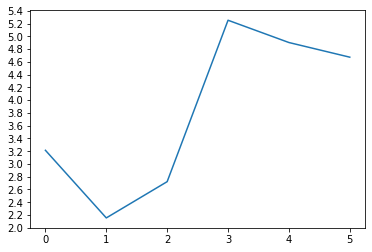

In [0]:
%matplotlib inline
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.2).to(device)

trainIters(encoder1, attn_decoder1, 1, print_every=50000, learning_rate=0.01)

torch.save(encoder1.state_dict(),'encoder_nmt_lstmbidim_gnhind.pkl')
torch.save(attn_decoder1.state_dict(),'decoder_nmt_lstmbidim_gnhind.pkl')

22m 48s (- 125m 12s) (50000 15%) 1.2537
44m 5s (- 99m 1s) (100000 30%) 0.9362
66m 21s (- 77m 14s) (150000 46%) 1.8131
90m 47s (- 56m 33s) (200000 61%) 4.2648
115m 35s (- 34m 29s) (250000 77%) 4.1000
140m 16s (- 11m 29s) (300000 92%) 3.9786


<Figure size 432x288 with 0 Axes>

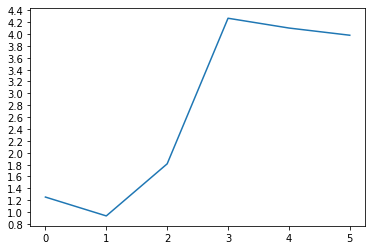

In [0]:
#Dint Save
trainIters(encoder1, attn_decoder1, 1, print_every=50000, learning_rate=0.01)

torch.save(encoder1.state_dict(),'encoder_nmt_lstmbidim_gnhind2.pkl')
torch.save(attn_decoder1.state_dict(),'decoder_nmt_lstmbidim_gnhind2.pkl')

In [0]:
%matplotlib inline
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.2).to(device)

encoder1.load_state_dict(torch.load("encoder_nmt_lstmbidim_gnhind.pkl"))
attn_decoder1.load_state_dict(torch.load("decoder_nmt_lstmbidim_gnhind.pkl"))

<All keys matched successfully>

In [0]:
trainIters(encoder1, attn_decoder1, 1, print_every=50000, learning_rate=0.01)
torch.save(encoder1.state_dict(),'encoder_nmt_lstmbidim_gnhind2.pkl')
torch.save(attn_decoder1.state_dict(),'decoder_nmt_lstmbidim_gnhind2.pkl')

29m 36s (- 162m 33s) (50000 15%) 1.2560
56m 59s (- 128m 0s) (100000 30%) 0.9345


32m 13s (- 176m 58s) (50000 15%) 0.8138
63m 39s (- 142m 58s) (100000 30%) 0.6531
96m 9s (- 111m 54s) (150000 46%) 1.4979
131m 31s (- 81m 55s) (200000 61%) 3.7284
166m 58s (- 49m 48s) (250000 77%) 3.6034
202m 31s (- 16m 35s) (300000 92%) 3.5133


<Figure size 432x288 with 0 Axes>

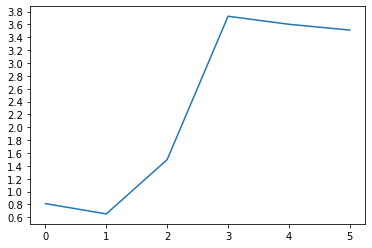

In [0]:
%matplotlib inline
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.2).to(device)

encoder1.load_state_dict(torch.load("encoder_nmt_lstmbidim_gnhind2.pkl"))
attn_decoder1.load_state_dict(torch.load("decoder_nmt_lstmbidim_gnhind2.pkl"))

trainIters(encoder1, attn_decoder1, 1, print_every=50000, learning_rate=0.01)
torch.save(encoder1.state_dict(),'encoder_nmt_lstmbidim_gnhind3.pkl')
torch.save(attn_decoder1.state_dict(),'decoder_nmt_lstmbidim_gnhind3.pkl')

In [0]:
%matplotlib inline
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.2).to(device)

encoder1.load_state_dict(torch.load("encoder_nmt_lstmbidim_gnhind3.pkl"))
attn_decoder1.load_state_dict(torch.load("decoder_nmt_lstmbidim_gnhind3.pkl"))

<All keys matched successfully>

23m 15s (- 127m 43s) (50000 15%) 0.6662
45m 0s (- 101m 5s) (100000 30%) 0.5386
67m 14s (- 78m 15s) (150000 46%) 1.3081
91m 43s (- 57m 8s) (200000 61%) 3.3266
116m 14s (- 34m 40s) (250000 77%) 3.2301
140m 34s (- 11m 31s) (300000 92%) 3.1651


<Figure size 432x288 with 0 Axes>

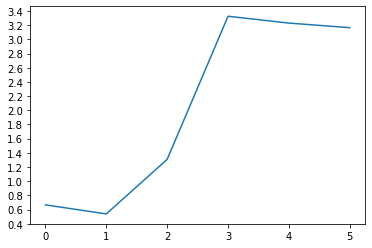

In [0]:
trainIters(encoder1, attn_decoder1, 1, print_every=50000, learning_rate=0.01)
torch.save(encoder1.state_dict(),'encoder_nmt_lstmbidim_gnhind4.pkl')
torch.save(attn_decoder1.state_dict(),'decoder_nmt_lstmbidim_gnhind4.pkl')

22m 49s (- 125m 18s) (50000 15%) 0.5953
44m 0s (- 98m 49s) (100000 30%) 0.4776
66m 1s (- 76m 51s) (150000 46%) 1.1755
90m 14s (- 56m 12s) (200000 61%) 3.0041
114m 33s (- 34m 10s) (250000 77%) 2.9243
138m 51s (- 11m 22s) (300000 92%) 2.8737


<Figure size 432x288 with 0 Axes>

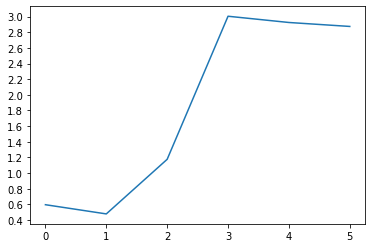

In [0]:
trainIters(encoder1, attn_decoder1, 1, print_every=50000, learning_rate=0.01)
torch.save(encoder1.state_dict(),'encoder_nmt_lstmbidim_gnhind5.pkl')
torch.save(attn_decoder1.state_dict(),'decoder_nmt_lstmbidim_gnhind5.pkl')

In [0]:
sent1 = "two dogs are running together through the grass"
sent2 = "man in red shirt and black pants is standing on wooden bench"
sent3 = "man in red jacket is sitting on rock"
sent4 = "man is battling waves in purple boat while wearing rain gear"
sent5 = "man in yellow suit is holding up cup while standing in snow"
sent6 = "blonde horse and blonde girl in black are staring at fire in barrel"
sent7 = "Two people and two horses watching fire"
sent8 = "small pale bird down to examine and small white bird looks at small object"

output_words1, attentions1 = evaluate(encoder1, attn_decoder1, sent1.lower())
output_words2, attentions2 = evaluate(encoder1, attn_decoder1, sent2.lower())
output_words3, attentions3 = evaluate(encoder1, attn_decoder1, sent3.lower())
output_words4, attentions4 = evaluate(encoder1, attn_decoder1, sent4.lower())
output_words5, attentions5 = evaluate(encoder1, attn_decoder1, sent5.lower())
output_words6, attentions6 = evaluate(encoder1, attn_decoder1, sent6.lower())
output_words7, attentions7 = evaluate(encoder1, attn_decoder1, sent7.lower())
output_words8, attentions8 = evaluate(encoder1, attn_decoder1, sent8.lower())

output_sentence1 = ' '.join(output_words1)
output_sentence2 = ' '.join(output_words2)
output_sentence3 = ' '.join(output_words3)
output_sentence4 = ' '.join(output_words4)
output_sentence5 = ' '.join(output_words5)
output_sentence6 = ' '.join(output_words6)
output_sentence7 = ' '.join(output_words7)
output_sentence8 = ' '.join(output_words8)


print('Predicted1: ', output_sentence1)
print('Predicted2: ', output_sentence2)
print('Predicted3: ', output_sentence3)
print('Predicted4: ', output_sentence4)
print('Predicted5: ', output_sentence5)
print('Predicted6: ', output_sentence6)
print('Predicted7: ', output_sentence7)
print('Predicted8: ', output_sentence8)

Predicted1:  दो से से दो से साथ हो 
Predicted2:  मृत्यु में में में और और में में में में में 
Predicted3:  लाल पर पर पर पर पर पर पर है 
Predicted4:  मुंबई में उनकी के में में में के में 
Predicted5:  इसमें में में के में में में में में में 
Predicted6:  तुर्की में में में और और और और की 
Predicted7:  दो लोग दो दो और दो 
Predicted8:  छोटा को छोटा छोटे छोटे पर छोटा और छोटे पर छोटा पर छोटा 


In [0]:
sent1 = "two brown dogs are playing in the snow"
sent2 = "a group of people are sitting on a bench"
sent3 = "a man in a blue shirt and blue shorts is on the street"
sent4 = "a football player in a red uniform is running"
sent5 = "a woman and a woman are smiling and smiling"
sent6 = "two dogs are running together through the grass"
# sent7 = "a man in a is on a big wave"
sent8 = "a men in a helmet rides a bike"
# sent9 = "a man in a on a surfboard"

output_words1, attentions1 = evaluate(encoder1, attn_decoder1, sent1.lower())
output_words2, attentions2 = evaluate(encoder1, attn_decoder1, sent2.lower())
output_words3, attentions3 = evaluate(encoder1, attn_decoder1, sent3.lower())
output_words4, attentions4 = evaluate(encoder1, attn_decoder1, sent4.lower())
output_words5, attentions5 = evaluate(encoder1, attn_decoder1, sent5.lower())
output_words6, attentions6 = evaluate(encoder1, attn_decoder1, sent6.lower())
# output_words7, attentions7 = evaluate(encoder1, attn_decoder1, sent7.lower())
output_words8, attentions8 = evaluate(encoder1, attn_decoder1, sent8.lower())
# output_words9, attentions9 = evaluate(encoder1, attn_decoder1, sent9.lower())

output_sentence1 = ' '.join(output_words1)
output_sentence2 = ' '.join(output_words2)
output_sentence3 = ' '.join(output_words3)
output_sentence4 = ' '.join(output_words4)
output_sentence5 = ' '.join(output_words5)
output_sentence6 = ' '.join(output_words6)
# output_sentence7 = ' '.join(output_words7)
output_sentence8 = ' '.join(output_words8)
# output_sentence9 = ' '.join(output_words9)


print('Predicted1: ', output_sentence1)
print('Predicted2: ', output_sentence2)
print('Predicted3: ', output_sentence3)
print('Predicted4: ', output_sentence4)
print('Predicted5: ', output_sentence5)
print('Predicted6: ', output_sentence6)
# print('Predicted7: ', output_sentence7)
print('Predicted8: ', output_sentence8)
# print('Predicted9: ', output_sentence9)

Predicted1:  कुछ की की में की में हैं। 
Predicted2:  लोग एक लोग के लोग एक एक का हैं 
Predicted3:  एक नीला पर नीला और नीला पर एक नीला पर 
Predicted4:  एक में में में में एक में है 
Predicted5:  औरत और औरत औरत और औरत औरत औरत 
Predicted6:  दो दो से से के हो 
Predicted8:  एक एक में एक में एक 
